In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from datetime import datetime
# To transfer file from Rpi to local machine, use in cmd:
# pscp hp@10.0.0.204:/home/hp/Desktop/16722_LAB_2/file_name.csv "C:\Users\HP\Desktop\Career Baby"



In [24]:
path = 'data/mic_data_lid_open_with_resistor.csv'
df = pd.read_csv(path)
df = df.dropna()  # Remove any NaN rows
t = df['time (s)'].values
x = df['voltage (V)'].values

In [25]:
# Estimate sampling frequency from timestamps (assumes uniform sampling)
dt = np.mean(np.diff(t))
fs = 1.0 / dt
print(f'Sampling frequency: {fs:.2f} Hz')

Sampling frequency: 1.00 Hz


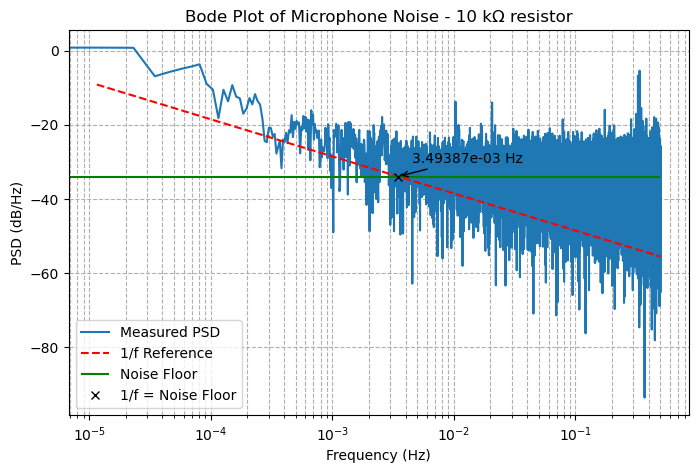

In [26]:
# Remove DC offset
x = x - np.mean(x)

# Compute PSD
f, Pxx = welch(x, fs=fs, nperseg=86400)

# Plot measured PSD
plt.figure(figsize=(8,5))
plt.semilogx(f, 10 * np.log10(Pxx), label='Measured PSD')

# 1/f reference line
f_ref = np.logspace(np.log10(f[1]), np.log10(f[-1]), 10000)  # updated: log-spaced for better resolution
freq_norm = 0.001
idx_norm = np.argmin(np.abs(f - freq_norm))
p_ref = Pxx[idx_norm]
ref_line = p_ref * (freq_norm / f_ref)
plt.semilogx(f_ref, 10 * np.log10(ref_line), 'r--', label='1/f Reference')

# Estimate and plot noise floor
hf_start = int(len(f) * 0.9)
noise_floor_level = np.median(Pxx[hf_start:])
plt.hlines(10 * np.log10(noise_floor_level), f[0], f[-1], colors='g', linestyles='-', label='Noise Floor')

# Find where 1/f reference intersects noise floor
from scipy.interpolate import interp1d

mask = ref_line < noise_floor_level
if np.any(mask):
    interp_func = interp1d(ref_line[mask], f_ref[mask], kind='linear', fill_value='extrapolate')
    f_cross = float(interp_func(noise_floor_level))
    P_cross = noise_floor_level
    plt.plot(f_cross, 10 * np.log10(P_cross), 'kx', label='1/f = Noise Floor')
    plt.annotate(f'{f_cross:.5e} Hz', 
                 xy=(f_cross, 10 * np.log10(P_cross)), 
                 xytext=(10, 10), 
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='black'),
                 fontsize=10)
else:
    f_cross = np.nan  # No intersection found

# Plot formatting
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (dB/Hz)')
plt.title('Bode Plot of Microphone Noise - 10 kΩ resistor')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()
